# Simulation of a Riemannian optimization
We simulate a dataset $\left\lbrace x_i\right\rbrace_i^n$ from a $p$-variate normal with mean $\mu$ and variance-covariance matrix $\Sigma$ and then we try to estimate both parameters via the maximization of the loglikelihood function
$$ \mathcal{L}(\mu, \Sigma) = \sum_i^n\log\left[\phi_{p}(x_i, \mu, \Sigma) \right] $$
where $\phi_{p}(x, \mu, \Sigma)$ is the density function of a $p$-variate gaussian distribution of mean $\mu$ and variance $\Sigma$.

We perform a reparametrization via data augmentation to obtain a convex function by expanding the data by adding a column of ones as $ y_i^\top = \left[x_i^\top 1 \right]$ and then we consider the expanded loglikelihood function
$$ \tilde{\mathcal{L}}(\Omega) = \sum_i^n\log\left[\sqrt{2\pi}e^{1/2}\phi_{p+1}(y_i, 0, \Omega) \right]. $$

It can be proven that if $\hat{\Omega}$ is the maximizer for $\tilde{\mathcal{L}}(\Omega)$ and $(\hat\mu, \hat\Sigma)$ is the maximizer for $\mathcal{L}(\mu,\Sigma)$, then
$$ \hat\Omega = \begin{pmatrix} \hat\Sigma + \hat\mu\hat\mu^\top & \hat\mu \\
    \hat\mu^\top & 1 \end{pmatrix}.$$

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import jit, random, grad
from jax.config import config
config.update('jax_enable_x64', True)

from tqdm.notebook import trange

seed = 42
RNG = random.PRNGKey(seed)

from libs.manifold import SPD
from libs.minimizer import OPTIM

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook")
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 7]
# plt.rcParams['figure.dpi'] = 100


Bad key "text.kerning_factor" on line 4 in
/home/jschiavon/.miniconda3/envs/pyintel/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
n_samples = 1000
p = 10
_tol = 1e-6

In [3]:
orig_man = SPD(p)
man = SPD(p + 1)
optim_rsd = OPTIM(man, method='rsd', mingradnorm=_tol, verbosity=0, logverbosity=True)
optim_rcg = OPTIM(man, method='rcg', mingradnorm=_tol, verbosity=0, logverbosity=True)


In [4]:
RNG, key = random.split(RNG)
t_cov = orig_man.rand(key)
RNG, key = random.split(RNG)
t_mean = random.normal(key, shape=(p,))
RNG, key = random.split(RNG)
data = random.multivariate_normal(key, mean=t_mean, cov=t_cov, shape=(n_samples,))
s_mu = jnp.mean(data, axis=0)
S = jnp.dot((data - s_mu).T, data - s_mu)
s_cov = S / n_samples
eigs = jnp.linalg.eigvalsh(s_cov)
min_eig, max_eig = min(eigs), max(eigs)

MLE = jnp.append(jnp.append(s_cov + jnp.outer(s_mu, s_mu), jnp.array([s_mu]), axis=0), 
                 jnp.array([jnp.append(s_mu, 1)]).T, axis=1)

In [5]:
def loglik(X):
    y = jnp.concatenate([data.T, jnp.ones(shape=(1, n_samples))], axis=0)
    S = jnp.dot(y, y.T)
    return - 0.5 * (n_samples * jnp.linalg.slogdet(X)[1] + jnp.trace(jnp.linalg.solve(X, S)))

fun_riem = jit(lambda X: - loglik(X))
gra_riem = jit(grad(fun_riem))

true_fun = fun_riem(MLE)
true_gra = gra_riem(MLE)
true_gra_norm = man.norm(MLE, true_gra)
print(true_fun)
print(true_gra_norm)

10386.751359527178
6.849195684682561e-07


In [6]:
for _ in trange(2):
    RNG, key = random.split(RNG)
    init = man.rand(key)
    
    # print(optim_rsd)
    results_rsd, log_rsd = optim_rsd.solve(fun_riem, gra_riem, x=init)
    # print(results_rsd, '\n')
    
    # print(optim_rcg)
    results_rcg, log_rcg = optim_rcg.solve(fun_riem, gra_riem, x=init)
    # print(results_rcg)

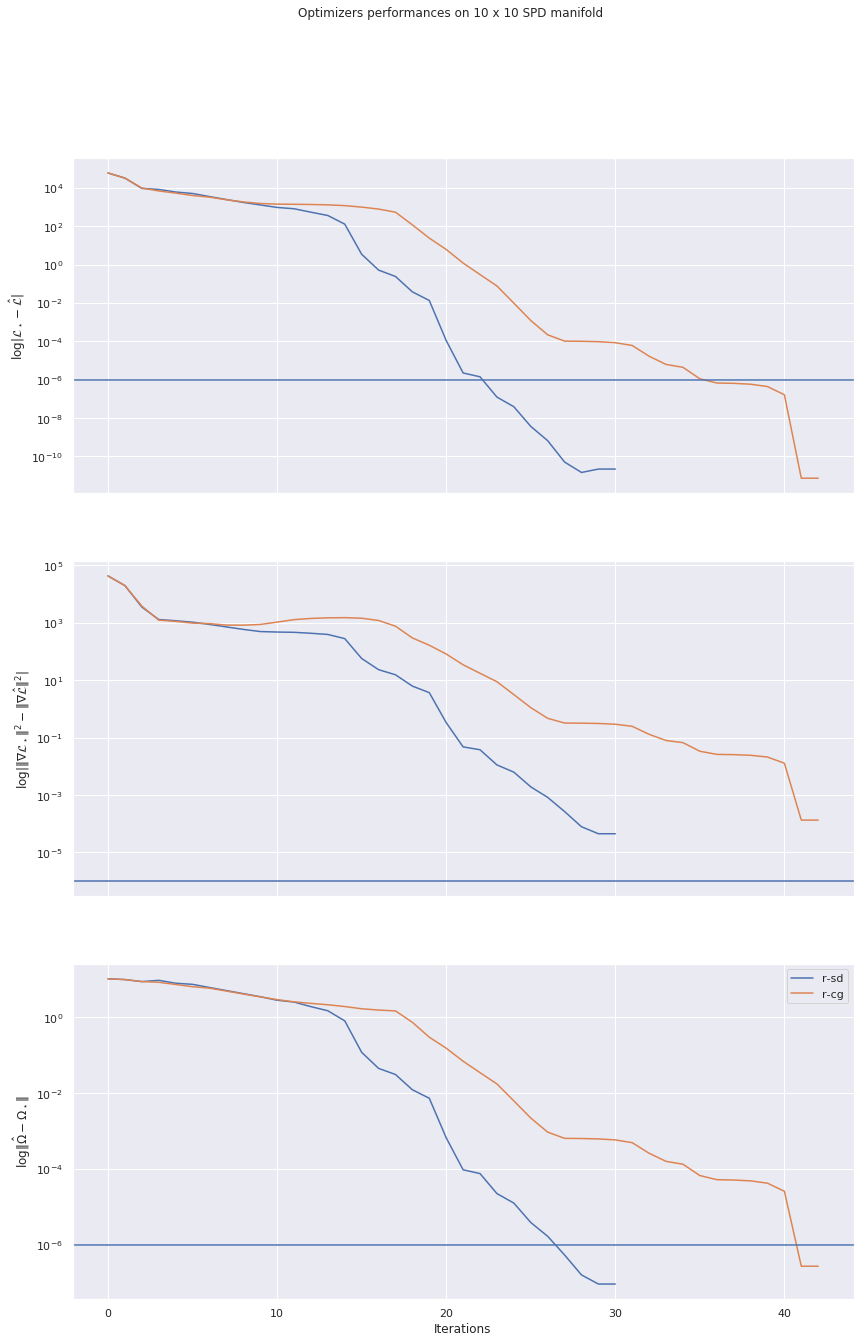

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 21))

ax1.plot(log_rsd.it, jnp.abs(log_rsd.fun - true_fun), label='r-sd');
ax1.plot(log_rcg.it, jnp.abs(log_rcg.fun - true_fun), label='r-cg');
ax1.axhline(y=_tol, xmin=0, xmax=max(results_rsd.nit, results_rcg.nit));
ax1.set_yscale('log');
ax1.set_ylabel(r'$\log\vert\mathcal{L}_\star - \hat{\mathcal{L}}\vert$');

ax2.plot(log_rsd.it, jnp.abs(log_rsd.grnorm - true_gra_norm), label='r-sd');
ax2.plot(log_rcg.it, jnp.abs(log_rcg.grnorm - true_gra_norm), label='r-cg'); 
ax2.axhline(y=_tol, xmin=0, xmax=max(results_rsd.nit, results_rcg.nit));
ax2.set_yscale('log');
ax2.set_ylabel(r'$\log\left\vert\Vert\nabla\mathcal{L}_\star\Vert^2 - \Vert\nabla\hat{\mathcal{L}}\Vert^2\right\vert$');

ax3.plot(log_rsd.it, [man.dist(MLE, log_rsd.x[i]) for i in range(results_rsd.nit+1)], label='r-sd'); 
ax3.plot(log_rcg.it, [man.dist(MLE, log_rcg.x[i]) for i in range(results_rcg.nit+1)], label='r-cg');
ax3.axhline(y=_tol, xmin=0, xmax=max(results_rsd.nit, results_rcg.nit));
ax3.set_yscale('log');
ax3.set_ylabel(r'$\log\left\Vert\hat\Omega - \Omega_\star\right\Vert$');

f.suptitle('Optimizers performances on {0} x {0} SPD manifold'.format(p));
plt.xlabel('Iterations');
plt.legend();
plt.show()

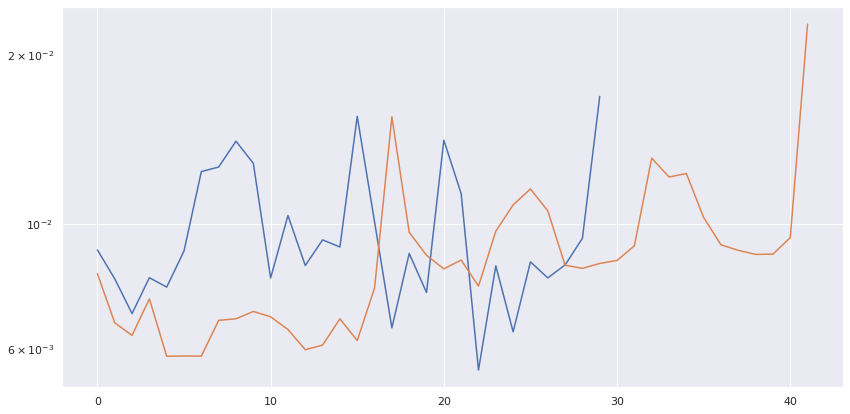

In [8]:
plt.plot(log_rsd.it[:-1], jnp.diff(log_rsd.time, 1))
plt.plot(log_rcg.it[:-1], jnp.diff(log_rcg.time, 1))
plt.yscale('log')
plt.show()

## Large simulation
We simulate various datasets with varying dimensions and repeat the experiment multiple times from multiple starting points.

**Warning**:

It takes quite a while to perform all the simulations (around 30 minutes on my i7 laptop)

In [9]:
seed = 42
RNG = random.PRNGKey(seed)

n_samples = 1000
ps = [10, 25, 50, 75, 100, 150, 200]
_tol = 1e-6

n_test = 10
n_reps = 5 # 10

tot_len = len(ps) * n_test * n_reps

In [10]:
mat_dim = np.zeros(shape=(tot_len * 2), dtype=int)
algo = ['R-SD', 'R-CG'] * tot_len
times = np.zeros(shape=(tot_len * 2))
iters = np.zeros(shape=(tot_len * 2), dtype=int)
fun_diff = np.zeros(shape=(tot_len * 2))
mat_diff = np.zeros(shape=(tot_len * 2))
grnorm = np.zeros(shape=(tot_len * 2))
i = 0

for p in ps:
    orig_man = SPD(p)
    man = SPD(p + 1)
    optim_rsd = OPTIM(man, method='rsd', maxiter=200, mingradnorm=_tol, verbosity=0)
    optim_rcg = OPTIM(man, method='rcg', maxiter=200, mingradnorm=_tol, verbosity=0)
    print(orig_man)
    
    for _ in trange(n_test):
        RNG, key = random.split(RNG)
        t_cov = orig_man.rand(key)
        RNG, key = random.split(RNG)
        t_mean = random.normal(key, shape=(p,))
        RNG, key = random.split(RNG)
        data = random.multivariate_normal(key, mean=t_mean, cov=t_cov, shape=(n_samples,))
        s_mu = jnp.mean(data, axis=0)
        S = jnp.dot((data - s_mu).T, data - s_mu)
        s_cov = S / n_samples
        eigs = jnp.linalg.eigvalsh(s_cov)
        min_eig, max_eig = min(eigs), max(eigs)

        MLE = jnp.append(jnp.append(s_cov + jnp.outer(s_mu, s_mu), jnp.array([s_mu]), axis=0), 
                         jnp.array([jnp.append(s_mu, 1)]).T, axis=1)
        
        def loglik(X):
            y = jnp.concatenate([data.T, jnp.ones(shape=(1, n_samples))], axis=0)
            S = jnp.dot(y, y.T)
            return - 0.5 * (n_samples * jnp.linalg.slogdet(X)[1] + jnp.trace(jnp.linalg.solve(X, S)))

        fun_riem = jit(lambda X: - loglik(X))
        gra_riem = jit(grad(fun_riem))

        true_fun = fun_riem(MLE)
        true_gra = gra_riem(MLE)
        true_gra_norm = man.norm(MLE, true_gra)
        
        for _ in range(n_reps):
            RNG, key = random.split(RNG)
            init = man.rand(key)
            
            for opt in [optim_rsd, optim_rcg]:
                result = opt.solve(fun_riem, gra_riem, x=init)
                mat_dim[i] = p + 1
                times[i] = float(result.time)
                iters[i] = int(result.nit)
                fun_diff[i] = float(result.fun - true_fun)
                mat_diff[i] = float(man.dist(MLE, result.x))
                grnorm[i] = float(result.grnorm)
                i += 1

df = pd.DataFrame({'p': mat_dim, 'algorithm': algo, 'time': times, 'iterations': iters, 'time / iterations': times / iters, 'fun diff': np.abs(fun_diff), 'mat diff': mat_diff, 'gradient norm': grnorm})

Manifold of (10 x 10) positive definite matrices



Manifold of (25 x 25) positive definite matrices



Manifold of (50 x 50) positive definite matrices



Manifold of (75 x 75) positive definite matrices



Manifold of (100 x 100) positive definite matrices



Manifold of (150 x 150) positive definite matrices



Manifold of (200 x 200) positive definite matrices


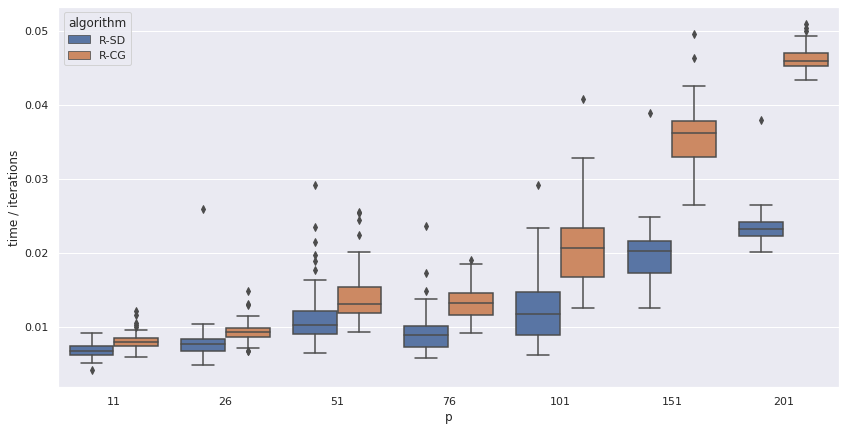

In [24]:
sns.boxplot(data=df, x='p', y='time / iterations', hue='algorithm')
#plt.yscale('log')
plt.show()

In [25]:
df.to_csv('sample_simulation.csv', index=False)